## Jacobian and element stiffness matrix calculation

In [3]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
#
"""
 A single quadrilateral element of rectangular shape.  Elementwise 
 conductivity matrix. Evaluated symbolically with numerical quadrature.
 """

from sympy import symbols, simplify, Matrix, det, diff

# Define the basis function matrix
xi, eta = symbols('xi eta')
N = Matrix([(xi-1)*(eta-1)/4, 
            (xi+1)*(eta-1)/-4, 
            (xi+1)*(eta+1)/4,
            (xi-1)*(eta+1)/-4]).reshape(4,1)
print(N)

#Define geometry
A, B = symbols('A, B')
x = Matrix([[A, B], [0, B], [0, 0], [A, 0]])

#  Differentiate to obtain the Basis function gradients
gradNpar = diff(N, 'xi').row_join(diff(N, 'eta'))
print(gradNpar)

# Compute the Jacobian matrix
J = x.T*gradNpar
print(simplify(J))
#  The Jacobian
Jac = det(J)
print(Jac)

#  The  gradient  of the basis functions with respect to x,y is a
#  symbolic expression which needs to be evaluated for particular values of
#  xi,eta
gradN = simplify(gradNpar*(J**-1))
print(gradN)

# We introduce the the thermal
# conductivity  and the thickness of the slice, as symbolic variables.
kap, Dz = symbols('kap, Dz')

# Note that using subs() will substitute the values of the parametric
# coordinates.  The Jacobian and the material properties and the thickness 
# of the slice are assumed constant and hence are not included in this sum. 
# The weights of the for quadrature points are all 1.0.
# The formula (4.13) will be recognizable in the following lines.
gN = gradN.subs(xi, -0.577350269189626).subs(eta, -0.577350269189626)
K1 = kap*Dz*Jac*gN*gN.T # term 1 of the sum
gN = gradN.subs(xi, -0.577350269189626).subs(eta, +0.577350269189626)
K2 = kap*Dz*Jac*gN*gN.T # term 2 of the sum
gN = gradN.subs(xi, +0.577350269189626).subs(eta, -0.577350269189626)
K3 = kap*Dz*Jac*gN*gN.T # term 3 of the sum
gN = gradN.subs(xi, +0.577350269189626).subs(eta, +0.577350269189626)
K4 = kap*Dz*Jac*gN*gN.T # term 4 of the sum

K = simplify(K1+K2+K3+K4)
print(K)

# print(K.eigenvals())

Matrix([[(eta - 1)*(xi - 1)/4], [-(eta - 1)*(xi + 1)/4], [(eta + 1)*(xi + 1)/4], [-(eta + 1)*(xi - 1)/4]])
Matrix([[eta/4 - 1/4, xi/4 - 1/4], [1/4 - eta/4, -xi/4 - 1/4], [eta/4 + 1/4, xi/4 + 1/4], [-eta/4 - 1/4, 1/4 - xi/4]])
Matrix([[-A/2, 0], [0, -B/2]])
A*B/4
Matrix([[(1 - eta)/(2*A), (1 - xi)/(2*B)], [(eta - 1)/(2*A), (xi + 1)/(2*B)], [-(eta + 1)/(2*A), -(xi + 1)/(2*B)], [(eta + 1)/(2*A), (xi - 1)/(2*B)]])
Matrix([[0.333333333333333*Dz*kap*(A**2 + B**2)/(A*B), Dz*kap*(0.166666666666667*A**2 - 0.333333333333333*B**2)/(A*B), -0.166666666666667*Dz*kap*(A**2 + B**2)/(A*B), Dz*kap*(-0.333333333333333*A**2 + 0.166666666666667*B**2)/(A*B)], [Dz*kap*(0.166666666666667*A**2 - 0.333333333333333*B**2)/(A*B), 0.333333333333333*Dz*kap*(A**2 + B**2)/(A*B), Dz*kap*(-0.333333333333333*A**2 + 0.166666666666667*B**2)/(A*B), -0.166666666666667*Dz*kap*(A**2 + B**2)/(A*B)], [-0.166666666666667*Dz*kap*(A**2 + B**2)/(A*B), Dz*kap*(-0.333333333333333*A**2 + 0.166666666666667*B**2)/(A*B), 0.333333333333333

## Concrete column example

In [4]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
#
"""
 Concrete column with temperature boundary condition.  Finite element mesh
 that consists of a single four-node quadrilateral.
 """

import math
from numpy import array as array
from numpy import zeros as zeros
from numpy import arange as arange
from numpy import dot as dot
from numpy import linalg as linalg

##
# Evaluate for a given data
a = 2.5  # radius of the column
b = a * math.sin(15.0 / 180 * math.pi)  # dimension
h = a * math.cos(15.0 / 180 * math.pi)  # dimension
Q = 4.5  # internal heat generation rate
k = 1.8  # thermal conductivity
Dz = 1.0  # thickness of the slice
x = array([[0, 0], [h, -b], [a, 0], [h, b]])  # Coordinates of nodes

##
# Define a little function to calculate the gradient of the basis functions
# in the parametric coordinates.


def gradNpar(xi, eta):
    """
    A one-liner to calculate the matrix of the basis function gradients
    in the parametric coordinates.
    """
    return array([
        [eta / 4 - 1. / 4, xi / 4 - 1. / 4],
        [1. / 4 - eta / 4, - xi / 4 - 1. / 4],
        [eta / 4 + 1. / 4, xi / 4 + 1. / 4],
        [- eta / 4 - 1. / 4, 1. / 4 - xi / 4]])

# The expressions actually come from  the following symbolic code:
#xi,eta = symbols('xi eta')
#N=Matrix([(xi-1)*(eta-1)/4, (xi+1)*(eta-1)/-4, (xi+1)*(eta+1)/4, (xi-1)*(eta+1)/-4])
# N=N.reshape(4,1)
# gradNpar=diff(N,'xi').row_join(diff(N,'eta'))
# print(gradNpar)

##
# These are the integration point data
xe = array([[-0.577350269189626, -0.577350269189626],
            [-0.577350269189626, +0.577350269189626],
            [+0.577350269189626, -0.577350269189626],
            [+0.577350269189626, +0.577350269189626]])
W = array([1, 1, 1, 1])

##
# Initialize the elementwise conductivity matrix.
Ke = zeros((4, 4))
##
# Loop over the quadrature points.
for qp in arange(xe.shape[0]):
    xi = xe[qp, 0]
    eta = xe[qp, 1]
    # Compute the Jacobian matrix
    J = dot(x.T, gradNpar(xi, eta))
    # The Jacobian
    detJ = linalg.det(J)
    # The  gradient  of the basis functions with respect to x,y
    gradN = dot(gradNpar(xi, eta), linalg.inv(J))
    # Add the contribution to the conductivity matrix
    Ke = Ke + k * Dz * dot(gradN, gradN.T) * detJ * W[qp]

print(Ke)

##
# We will find it convenient to define a little function to evaluate the
# basis function values at a given quadrature point location.


def N(xi, eta):
    """
    A one-liner to calculate the matrix of the basis function values.
    """
    return array([(xi - 1) * (eta - 1) / 4,
                  (xi + 1) * (eta - 1) / -4,
                  (xi + 1) * (eta + 1) / 4,
                  (xi - 1) * (eta + 1) / -4]).reshape(4, 1)

##
# Initialize the elementwise heat-load vector .
Le = zeros((4, 1))
##
# Loop over the quadrature points.
for qp in arange(xe.shape[0]):
    xi = xe[qp, 0]
    eta = xe[qp, 1]
    # Compute the Jacobian matrix
    J = dot(x.T, gradNpar(xi, eta))
    # The Jacobian
    detJ = linalg.det(J)
    # Add the contribution to the heat load vector
    Le = Le + Q * Dz * N(xi, eta) * detJ * W[qp]

print(Le)

# Global system matrix and global load vector
K = Ke
L = Le

##
# The solution vector consists of all zeros, except in the first entry.
T = zeros((4, 1))
# Solve the global equations
T[0] = (1 / K[0, 0]) * L[0]
print('T_1 = ', T[0])

#
# Now we will postprocess to extract the heat flux vectors at the
# quadrature points.
##
# Loop over the quadrature points.
for qp in arange(xe.shape[0]):
    xi = xe[qp, 0]
    eta = xe[qp, 1]
    # Compute the location of the quadrature point
    qploc = dot(N(xi, eta).T, x)
    # Compute the Jacobian matrix
    J = dot(x.T, gradNpar(xi, eta))
    # The  gradient  of the basis functions with respect to x, y
    gradN = dot(gradNpar(xi, eta), linalg.inv(J))
    # Compute the gradient of temperature
    gradT = dot(T.T, gradN)
    # Heat flux vector
    q = -k * gradT.T
    print('Heat flux at', qploc, '  = ', q)



[[ 0.46772756 -0.02719481 -0.41333794 -0.02719481]
 [-0.02719481  2.13771962 -0.77091145 -1.33961336]
 [-0.41333794 -0.77091145  1.95516084 -0.77091145]
 [-0.02719481 -1.33961336 -0.77091145  2.13771962]]
[[2.38508927]
 [1.81982141]
 [1.25455355]
 [1.81982141]]
T_1 =  [5.09931307]
Heat flux at [[ 9.16583685e-01 -4.89731671e-18]]   =  [[3.76543041e+00]
 [8.99357186e-16]]
Heat flux at [[2.02654304 0.37357311]]   =  [[3.67150541]
 [0.27906968]]
Heat flux at [[ 2.02654304 -0.37357311]]   =  [[ 3.67150541]
 [-0.27906968]]
Heat flux at [[ 2.35995936e+00 -4.89731671e-18]]   =  [[3.35882447e+00]
 [8.44564073e-16]]


### Square domain with partial temperature boundary conditions and partial insulated boundary condition

Time = 0.6342267990112305


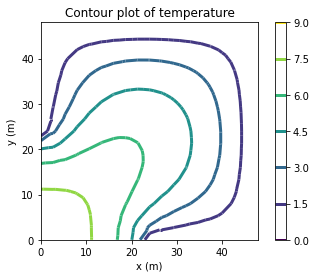

In [5]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
#
"""
Square domain with partial temperature boundary condition
and partial insulated boundary condition.  Finite element mesh
that consists of four-node quadrilaterals.
 """

import math
from numpy import array, zeros, ones, arange, linspace
from numpy import unique, dot, linalg
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import time

tstart = time.time() 

# Input parameters
kappa = 0.2 # thermal conductivity
Q = 0.005 # uniform heat source
sidel = 48 # length of the side of the square domain
nes = 18 # number of elements per side
Dz = 1.0  # thickness of the slice

# Generate the nodes and the connectivities of the quadrilaterals
xs = linspace(0, sidel, nes+1) # grid in the X direction
ys = linspace(0, sidel, nes+1) # grid in the Y direction
nx = len(xs) - 1 # number of element edges in the X direction
ny = len(ys) - 1 # number of element edges in the Y direction
nnodes = (nx+1) * (ny+1) # Number of nodes
nfes = nx * ny # Number of elements

# Generate the nodes
x = zeros((nnodes, 2)) # Coordinates of nodes: initialized to all zeros
k = 0
for j  in arange(0, (ny+1)):
    for i  in arange(0, (nx+1)):
        x[k, :] = [xs[i], ys[j]]
        k = k + 1

# Generate the elements: note that the nodes are numbered from 1
conn = zeros((nfes, 4), dtype=int)
k = 0
for i  in arange(0, (nx)):
    for j  in arange(0, (ny)):
        f = int(j * (nx+1) + i) + 1
        conn[k, :] = [f, f+1, f+(nx+1)+1, f+(nx+1)]
        k = k + 1

# Define the degrees of freedom
# Fixed temperature at the nodes on the boundary, except for a few
# in the lower-left corner.  The  node numbers are one-based
Fixed = [int(i)+1 for i in arange(nx/2, nx+1)]
Fixed = Fixed + [int(j*(nx+1))+1 for j in arange(ny/2, ny+1)]
Fixed = Fixed + [int(i+ny*(nx+1))+1 for i in arange(0, nx+1)]
Fixed = Fixed + [int(j*(nx+1)+ny)+1 for j in arange(0, ny+1)]
Fixed = unique(Fixed)

dof = zeros((nnodes,1), dtype=int)
N_f = nnodes - len(Fixed) # number of free degrees of freedom
N_t = nnodes # total number of degrees of freedom

T = zeros((nnodes,1)) # vector of degrees of freedom

# Number the degrees of freedom: First we will number the prescribed 
# degrees of freedom starting from the number of free degrees of freedom
k = N_f # first we number the prescribed degrees of freedom
for index  in Fixed:
    dof[index-1] = k+1 # the DOF are 1-based
    k = k + 1
k = 0 # next we number the free degrees of freedom  
for index  in range(0, nnodes):
    if (dof[index] == 0): 
        dof[index] = k+1 # the DOF are 1-based
        k = k + 1

    
def gradNpar(xi, eta):
    """
    A one-liner to calculate the matrix of the basis function gradients
    in the parametric coordinates.
    """
    return array([
        [eta / 4 - 1. / 4, xi / 4 - 1. / 4],
        [1. / 4 - eta / 4, - xi / 4 - 1. / 4],
        [eta / 4 + 1. / 4, xi / 4 + 1. / 4],
        [- eta / 4 - 1. / 4, 1. / 4 - xi / 4]])
 
def N(xi, eta):
    """
    A one-liner to calculate the matrix of the basis function values.
    """
    return array([(xi - 1) * (eta - 1) / 4,
                  (xi + 1) * (eta - 1) / -4,
                  (xi + 1) * (eta + 1) / 4,
                  (xi - 1) * (eta + 1) / -4]).reshape(4, 1)
 
# These are the integration point data for four-point quadrature rule
xe = array([[-0.577350269189626, -0.577350269189626],
            [-0.577350269189626, +0.577350269189626],
            [+0.577350269189626, -0.577350269189626],
            [+0.577350269189626, +0.577350269189626]])
W = array([1, 1, 1, 1])

# These are the integration point data for one-point quadrature rule
#xe = array([[+0., +0]])
#W = array([4.0])

K = zeros((N_f, N_t))
L = zeros((N_f, 1))
 
nnpe = conn.shape[1] # number of nodes per element
zconn = conn - 1
for index  in arange(conn.shape[0]):
    # Element degree-of-freedom array,  converted to zero base
    zedof = dof[zconn[index, :]]-1
    # Initialize the elementwise conductivity matrix.
    Ke = zeros((nnpe, nnpe))
    # Initialize the elementwise heat load vector   
    LQe = zeros((nnpe, 1))
    # Loop over the quadrature points.
    for qp in range(xe.shape[0]):
        xi, eta = xe[qp, 0], xe[qp, 1]
        lx = x[zconn[index, :], :]
        # Compute the Jacobian matrix
        J = dot(lx.T, gradNpar(xi, eta))
        # The Jacobian
        detJ = linalg.det(J)
        # The  gradient  of the basis functions with respect to x,y
        gradN = dot(gradNpar(xi, eta), linalg.inv(J))
        # Add the contribution to the conductivity matrix
        Ke = Ke + kappa * Dz * dot(gradN, gradN.T) * detJ * W[qp]
        # At the contribution to the elementwise heat load vector
        LQe = LQe + Q * Dz * N(xi, eta) * ones((nnpe, 1)) * detJ * W[qp]
    # Assemble elementwise conductivity matrix
    for ro  in range(len(zedof)):
        for co  in range(len(zedof)):
            if (zedof[ro] < N_f):
                K[zedof[ro], zedof[co]] = K[zedof[ro], zedof[co]] + Ke[ro, co]
    # Assemble the elementwise heat load vector   
    for ro  in range(len(zedof)):
        if (zedof[ro] < N_f):
            L[zedof[ro]] = L[zedof[ro]] + LQe[ro]   

# Solve for the global temperatures at the free degrees of freedom
T[0:N_f] = linalg.solve(K[0:N_f, 0:N_f], L)

tend = time.time() 
print( 'Time =', tend-tstart)

if (len(T) < 10):
    print('Tg=', Tg)

# Plot contours
plt.figure()
plt.gca().set_aspect('equal')
# setup three 1-d arrays for the x-coordinate, the y-coordinate, and the
# z-coordinate
xs = x[:, 0].reshape(nnodes,)  # one value per node
ys = x[:, 1].reshape(nnodes,)  # one value per node
ix = dof[arange(nnodes)] - 1
zs = (T[ix]).reshape(nnodes,)  # one value per node
triangles = conn[:, (0, 1, 2)] - 1  # the triangles are defined by the connectivity arrays
plt.tricontour(xs, ys, triangles, zs, linewidths=3)
triangles = conn[:, (0, 2, 3)] - 1  # the triangles are defined by the connectivity arrays
plt.tricontour(xs, ys, triangles, zs, linewidths=3)
plt.colorbar()
plt.title('Contour plot of temperature')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

## Solid Mechanics

### Strain calculation in triangle element

In [6]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
#
"""
Strain patterns calculated for a single triangle.
"""

from numpy import array, dot, linalg

##
xall = array([[-1, -1/2], [3, 2], [1, 2]]) #Coordinates of the nodes
conn = [1, 2, 3] # The definition of the element, listing its nodes

gradNpar = array([[-1, -1], [1, 0], [0, 1]])  #Gradients of the basis fncs wrt the param. coords
zconn = array(conn)-1
x = xall[zconn,:] # The coordinates  of the three nodes
J = dot(x.T, gradNpar) # Compute the Jacobian matrix
gradN = dot(gradNpar, linalg.inv(J))

def Bn(gradNn):
    """
    One-liner function to compute the nodal strain-displacement matrix.
    """
    return array([[gradNn[0], 0],
                  [0, gradNn[1]],
                  [gradNn[1], gradNn[0]]])

B1=Bn(gradN[0,:])
B2=Bn(gradN[1,:])
B3=Bn(gradN[2,:])

from sympy import symbols, Matrix, simplify

DeltaT, CTE, E, nu, t  = symbols('DeltaT CTE E nu t')
D = E/(1-nu**2)*Matrix([[1, nu, 0], [nu, 1, 0], [0, 0, (1-nu)/2]])
eth = DeltaT*CTE*Matrix([1, 1, 0]).reshape(3, 1)
sig = D*eth
Se = linalg.det(J)/2
F1 = simplify(Se*t*B1.T*sig)
F2 = simplify(Se*t*B2.T*sig)
F3 = simplify(Se*t*B3.T*sig)
print('Thermal forces')
print('Node 1:', F1)
print('Node 2:', F2)
print('Node 3:', F3)

Thermal forces
Node 1: Matrix([[0], [1.0*CTE*DeltaT*E*t/(nu - 1)]])
Node 2: Matrix([[-1.25*CTE*DeltaT*E*t/(nu - 1)], [1.0*CTE*DeltaT*E*t/(nu - 1)]])
Node 3: Matrix([[1.25*CTE*DeltaT*E*t/(nu - 1)], [-2.0*CTE*DeltaT*E*t/(nu - 1)]])


## Richardson extrapolation

xestim, beta, c, residual = 92.46031652777476 0.6053628424093497 -2.471055221256022 [0.0, 5.534461777756405e-13, 3.6376457401843254e-13]
to be compared with  92.46031652777476 0.6053628424093497 -2.471055221256022 [0.0, 5.534461777756405e-13, 3.6376457401843254e-13]
xestim, beta, c, residual = 11.989892116202842 2.485429379525128 -1.1344074299887144 [0.0, -8.93729534823251e-15, -1.5959455978986625e-15]
to be compared with  11.989892116202842 2.485429379525128 -1.1344074299887144 [0.0, -8.93729534823251e-15, -1.5959455978986625e-15]
xestim, beta, c, residual = 18.25299931817398 1.7550849296401745 -0.3029825595040225 [0.0, -3.975153539670373e-13, -1.1776647365624449e-13]
to be compared with  18.25299931817398 1.7550849296401745 -0.3029825595040225 [0.0, -3.975153539670373e-13, -1.1776647365624449e-13]
xestim, beta, c = 263.91176470588067 1.1697126080157385 32.21176470588068
to be compared with  263.91176470588067 1.1697126080157385 32.21176470588068
xestim, beta, c = 6.662276425853192 1.

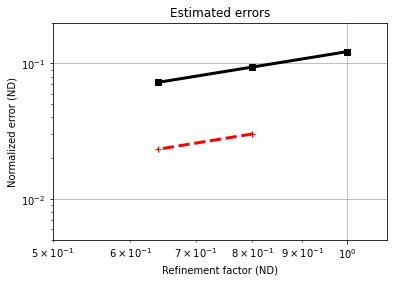

267.6000000000001
1.1697126080156461
263.9119987616654


In [9]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
"""
Richardson extrapolation.
"""

import math
from numpy import diff

def bisection(fun, xl, xu, tolx, tolf):
    if (xl > xu):
        xl, xu = xu, xl
    fl = fun(xl);
    fu = fun(xu);
    while True:
        xr = (xu + xl) * 0.5  # bisect interval
        fr = fun(xr)  # value at the midpoint
        if fr * fl < 0.0: # (fr < 0.0 && fl > 0.0) || (fr > 0.0 && fl < 0.0)
            xu, fu = xr, fr # upper --> midpoint
        else:
            xl, fl = xr, fr # lower --> midpoint
        if (abs(xu-xl) < tolx) or (abs(fr) <= tolf):
            return xl, xu # We are done
    return xl, xu

def richextrapol(xs, hs):
    """
    Richardson extrapolation.

     xestim, beta, c, residual = richextrapol(xs,hs)

    Richardson extrapolation. This function is applicable to fixed ratio
    between the element sizes, hs[0]/hs[1] == hs[1]/hs[2], in which case
    the solution follows explicitly, But it is also applicable to non-uniform
    refinement factor (for arbitrary element sizes).

    Arguments
         xs = list of the calculated quantities,
         hs = list of the element sizes

    Returns
        xestim= estimate of the asymptotic solution from the data points
            in the xs array
        beta= convergence rate
        c = constant in the estimate "error = c*h**beta"
        residual = residual after equations from which the above quantities were
            solved (this is a measure of how accurately was the system solved)
    """
    # Normalize the solutions so that we work with nice numbers
    nxs = [x/xs[0] for x in xs]
    c, beta = 0.0, 1.0 # some defaults to be overwritten below
    if abs(hs[0]/hs[1] - hs[1]/hs[2]) > 1.0e-6:
        # In the hard case, with a non-uniform refinement factor, we must
        #        solve a nonlinear equation 1st.
        nea1 = nxs[1]-nxs[0]
        nea2 = nxs[2]-nxs[1]
        tol = 0.000000001
        h0, h1, h2 = hs[0], hs[1], hs[2]
        eqn = lambda b: nea1 - nea2 * ((-h1**b+h0**b) / (-h2**b+h1**b))
        lo = tol # lower bound on the convergence rate
        hi = 10.0
        b1, b2 = bisection(eqn, lo, hi, tol, tol)
        beta = (b1 + b2) / 2.0
        c = xs[0]*nea1/(-hs[1]**beta+hs[0]**beta)
        xestim = xs[2] + c * hs[2]**beta
    else:
        # In the easy case, with a uniform refinement factor, the solution
        #        is obtained explicitly.
        xestim = ((-(nxs[0]*nxs[2]-nxs[1]**2)/(2*nxs[1]-nxs[0]-nxs[2])))*xs[0]
        if (xestim-xs[0]) <= 0:
            beta = math.log((xestim-xs[1])/(xestim-xs[2]))/math.log(hs[1]/hs[2])
        else:
            beta = math.log((xestim-xs[0])/(xestim-xs[2]))/math.log(hs[0]/hs[2])
        c = (xestim-xs[0])/hs[0]**beta
    #
    # just to check things, calculate the residual
    residual = [0, 0, 0]
    for I in range(0, 3):
        residual[I] = (xestim-xs[I])-c*hs[I]**beta# this should be close to zero
    #
    return xestim, beta, c, residual

def _test():
    """
    Test of Richardson extrapolation.
    """
    xs = [93.0734, 92.8633, 92.7252]
    hs = [0.1000, 0.0500, 0.0250]
    xestim, beta, c, residual = richextrapol(xs, hs)
    print('xestim, beta, c, residual =', xestim, beta, c, residual)
    print('to be compared with ', 92.46031652777476, 0.6053628424093497, -2.471055221256022, \
          [0.0, 5.534461777756405e-13, 3.6376457401843254e-13])
    #
    xs = [13.124299546191557, 12.192464513175167, 12.026065694522512]
    hs = [1.0, 0.5, 0.25]
    xestim, beta, c, residual = richextrapol(xs, hs)
    print('xestim, beta, c, residual =', xestim, beta, c, residual)
    print('to be compared with ', 11.989892116202842, 2.485429379525128, -1.1344074299887144, \
          [0.0, -8.93729534823251e-15, -1.5959455978986625e-15])
    #
    xs = [18.279591331058882, 18.260877354949294, 18.255333231883284]
    hs = [0.25, 0.125, 0.0625]
    xestim, beta, c, residual = richextrapol(xs, hs)
    print('xestim, beta, c, residual =', xestim, beta, c, residual)
    print('to be compared with ', 18.25299931817398, 1.7550849296401745, -0.3029825595040225, \
          [0.0, -3.975153539670373e-13, -1.1776647365624449e-13])
    #
    sol = [231.7, 239.1, 244.8]
    h = [(4./5.)**i for i in range(0, 3)]
    xestim, beta, c, residual = richextrapol(sol, h)
    print('xestim, beta, c =', xestim, beta, c)
    print('to be compared with ', 263.91176470588067, 1.1697126080157385, 32.21176470588068)
    #
    # This Tests the case of non-uniform refinement factor
    sol = [7.446, 7.291, 6.87] # f = lambda h: -3.333 * h**1.2 + 6.66
    h = [0.3, 0.25, 0.1]
    xestim, beta, c, residual = richextrapol(sol, h)
    print('xestim, beta, c =', xestim, beta, c)
    print('to be compared with ', 6.66, 1.2, -3.333)

_test()

def examples():
    """
    Examples from the textbook.
    """
    sol = [231.7, 239.1, 244.8]
    h = [(4./5.)**i for i in range(0, 3)]
    xestim, beta, c, residual = richextrapol(sol, h)
    print('xestim, beta, c =', xestim, beta, c)
    #
    Ea = diff(sol)
    print(Ea)
    # Plotting
    import matplotlib.pyplot as plt
    plt.figure()
    plt.xlim((0.5, 1.1))
    plt.ylim((0.005, 0.2))
    # Normalized true error estimate
    nEt = [(xestim-s)/xestim for s in sol]
    plt.loglog(h, nEt, 'k-s', linewidth=3)
    plt.loglog(h[1:3], Ea/max(sol), 'r--+', linewidth=3)
    #
    plt.grid()
    plt.title('Estimated errors')
    plt.xlabel('Refinement factor (ND)')
    plt.ylabel('Normalized error (ND)')
    plt.show()
    #
    from math import log
    print(sol[1]+(sol[2]-sol[1])/(1-(4/5)**1.0))
    print((log(Ea[1])-log(Ea[0]))/(log(h[2])-log(h[1])))
    print(sol[1]+(sol[2]-sol[1])/(1-(4/5)**1.1697))

examples()

J =  [[0.3        0.35857864]
 [0.         0.14142136]]
gardN =  [[-3.33333333  1.38071187]
 [ 3.33333333 -8.45177969]
 [ 0.          7.07106781]] inv(J) =  [[ 3.33333333 -8.45177969]
 [ 0.          7.07106781]]
det(Ke) =  1.163065468650124e-15
det(J)/2 =  0.021213203435596423
Ke =  [[ 0.82842712 -1.44974747  0.62132034]
 [-1.44974747  5.25304833 -3.80330086]
 [ 0.62132034 -3.80330086  3.18198052]]
J =  [[ 0.          0.35857864]
 [-0.25       -0.10857864]]
gardN =  [[-1.57757701  4.        ]
 [-1.21121149 -4.        ]
 [ 2.78878851  0.        ]] inv(J) =  [[-1.21121149 -4.        ]
 [ 2.78878851  0.        ]]
det(Ke) =  -9.042989727347138e-16
det(J)/2 =  0.04482233047033632
Ke =  [[ 2.48612648 -1.8945351  -0.59159138]
 [-1.8945351   2.34873941 -0.45420431]
 [-0.59159138 -0.45420431  1.04579569]]
J =  [[ 0.35857864  0.        ]
 [-0.10857864  0.25      ]]
gardN =  [[-4.         -4.        ]
 [ 2.78878851  0.        ]
 [ 1.21121149  4.        ]] inv(J) =  [[2.78878851 0.        ]
 [1.21

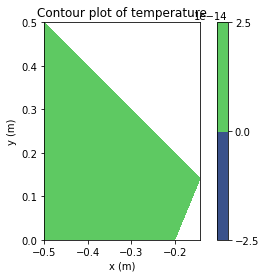

In [29]:
import math
from numpy import array as array 
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import arange as arange
from numpy import dot as dot
from numpy import linalg as linalg
from numpy import vstack  as vstack
from numpy import diff as diff
import matplotlib.pyplot as plt


A = 0.5
R = 0.2
k = 3  # thermal conductivity
Dz = 1.0  # thickness of the slice
h = 150  # surface heat transfer coefficient
Ta = -7.0  # ambient air temperature

# Coordinates of nodes
x = array([[-A, A], [-A, A/2], [-A,0], [-R,0], [-math.sqrt(2)*R/(2),math.sqrt(2)*R/(2)]])

dof = array([3,2,1,4,5]) # degrees of freedom

N = 5 # Number of all degrees of freedom
N_f = 5 #As two of the temp values are known


Tw = 80.0 # Water Temperature 
T = zeros(N).reshape(N, 1)

T[N_f:N] = Tw #Nodes having constant temp value

gradNpar = array([[-1, -1], [1, 0], [0, 1]])

conn = array([[3,4,5], [2, 3, 5],[2,5,1]]) #Connectivity matrix
connbdry = array([[2, 1]]) ## boundary connectivity

K = zeros((N_f, N))  # global conductivity matrix
L = zeros((N_f, 1))  # global heat loads vector

# Loop over the triangles in the mesh
zconn = conn - 1
for j  in arange(zconn.shape[0]):
    J = dot(x[zconn[j, :], :].T, gradNpar)# compute the Jacobian matr , x[zconn[j, :], :].T
    print("J = ",J)
    gradN = dot(gradNpar, linalg.inv(J)) # gradient wrt x y coordinate system
    print("gardN = ",gradN, "inv(J) = ",linalg.inv(J))
    Ke = (k*Dz*linalg.det(J)/2)*dot(gradN, gradN.T) # elementwise matrix
    print('det(Ke) = ', linalg.det(Ke))
    print("det(J)/2 = ",linalg.det(J)/2)
    print("Ke = ",Ke)
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(dof[zconn[j, :]])-1
    zedof
    # Assemble of conductivity matrix
    for i  in arange(len(zedof)):
        for j  in arange(len(zedof)):
            if (zedof[i] < N_f):
                K[zedof[i], zedof[j]] = K[zedof[i], zedof[j]] + Ke[i, j]

print('K =',K)
# Calculations for the  convection boundary condition
H = zeros((N_f, N))  # global film-condition matrix
zconn = connbdry - 1
print("zconn = ",zconn,zconn.shape[0] )
for j in arange(zconn.shape[0]):
    he = linalg.norm(diff(x[zconn[j, :], :], axis=0))
    print("x1-x2 = ",diff(x[zconn[j, :], :]))
    print("length he = ",he)
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(dof[zconn[j, :]]) - 1
    He = h * Dz * he / 6 * array([[2, 1], [1, 2]])
    print("He = ",He)
    # Assemble elementwise surface heat transfer matrix
    for i in arange(len(zedof)):
        for j in arange(len(zedof)):
            if (zedof[i] < N_f):
                H[zedof[i], zedof[j]] = H[zedof[i], zedof[j]] + He[i, j]
    # Assemble elementwise heat load vector for surface heat transfer
    Lea = Ta * h * he * Dz / 2 * array([[1], [1]])
    print("Lea =",Lea)
    for i in arange(len(zedof)):
        if (zedof[i] < N_f):
            L[zedof[i]] = L[zedof[i]] + Lea[i]

# Solve for the global temperatures at the free degrees of freedom
print("K = ",K)
print("H = ",H)
print(L)
# Solve for the global temperatures at the free degrees of freedom
T[0:N_f] = linalg.solve(K[0:N_f, 0:N_f] + H[0:N_f, 0:N_f], L)
print("Hfinal = ", H[0:N_f, 0:N_f])
print("Kfinal = ", K[0:N_f, 0:N_f])
print("H + K = ",K[0:N_f, 0:N_f] + H[0:N_f, 0:N_f])
print('T=', T)

print('Temperatures at the nodes')
for index in arange(dof.shape[0]):
    print('Node', index + 1, 'T=', T[dof[index] - 1])

# Plot filled contours
plt.figure()
plt.gca().set_aspect('equal')
# setup three 1-d arrays for the x-coordinate, the y-coordinate, and the
# z-coordinate
xs = x[:, 0].reshape(N,)  # one value per node
ys = x[:, 1].reshape(N,)  # one value per node
ix = dof[arange(N)] - 1
print(ix)
zs = (T[ix]).reshape(N,) # one value per node
triangles = conn - 1  # the triangles are defined by the connectivity arrays
plt.tricontourf(xs, ys, triangles, zs)
plt.colorbar()
plt.title('Contour plot of temperature')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()


In [18]:
x

array([[-0.5       ,  0.5       ],
       [-0.5       ,  0.25      ],
       [-0.5       ,  0.        ],
       [-0.2       ,  0.        ],
       [-3.53553391,  3.53553391]])